In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%run main.py


Output shape: (5, 2)


Load MNIST dataset

In [3]:

# Load MNIST dataset
(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)



In [4]:

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, (-1,))  # Flatten the image
    label = tf.one_hot(label, 10)  # One-hot encode the label
    return image, label

 Prepare the Data

In [5]:
ds_train = ds_train.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

In [6]:
def display_images(dataset, num_images):
    plt.figure(figsize=(12, 12))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(1, num_images, i+1)
        plt.imshow(tf.reshape(image, (28, 28)), cmap='gray')
        plt.title(f"Label: {tf.argmax(label).numpy()}")
        plt.axis("on")
    plt.show()

 Define your neural network model

In [7]:

def neural_network_model(inputs):
    hidden1 = tf.keras.layers.Dense(512, activation=tf.nn.relu, name='hidden1')(inputs)
    hidden2 = tf.keras.layers.Dense(256, activation=tf.nn.relu, name='hidden2')(hidden1)
    hidden3 = tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden3')(hidden2)
    output = tf.keras.layers.Dense(10, name='output')(hidden3)
    return output

In [8]:
inputs = tf.keras.Input(shape=(784,), name='X')
targets = tf.keras.Input(shape=(10,), name='Y')
logits = neural_network_model(tf.keras.layers.Flatten()(inputs))


In [9]:
biases = {
    'b1': tf.Variable(tf.constant(0.1, shape=[512]), name='b1'),
    'b2': tf.Variable(tf.constant(0.1, shape=[256]), name='b2'),
    'b3': tf.Variable(tf.constant(0.1, shape=[128]), name='b3'),
    'out': tf.Variable(tf.constant(0.1, shape=[10]), name='bout'),
}


Compile the Model

In [10]:
# Define the model and compile with loss and optimizer
model = tf.keras.Model(inputs=inputs, outputs=logits)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



 Train the model

In [11]:

history = model.fit(ds_train, epochs=20, validation_data=ds_test)

Epoch 1/20
469/469 [==============================] - 48s 96ms/step - loss: 0.2302 - accuracy: 0.9322 - val_loss: 0.1170 - val_accuracy: 0.9643
Epoch 2/20
469/469 [==============================] - 33s 71ms/step - loss: 0.0830 - accuracy: 0.9743 - val_loss: 0.0814 - val_accuracy: 0.9753
Epoch 3/20
469/469 [==============================] - 42s 90ms/step - loss: 0.0543 - accuracy: 0.9833 - val_loss: 0.0730 - val_accuracy: 0.9768
Epoch 4/20
469/469 [==============================] - 49s 104ms/step - loss: 0.0385 - accuracy: 0.9878 - val_loss: 0.0873 - val_accuracy: 0.9756
Epoch 5/20
469/469 [==============================] - 43s 90ms/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.0807 - val_accuracy: 0.9773
Epoch 6/20
469/469 [==============================] - 42s 88ms/step - loss: 0.0263 - accuracy: 0.9915 - val_loss: 0.1137 - val_accuracy: 0.9716
Epoch 7/20
469/469 [==============================] - 50s 106ms/step - loss: 0.0219 - accuracy: 0.9925 - val_loss: 0.1146 - val_accurac

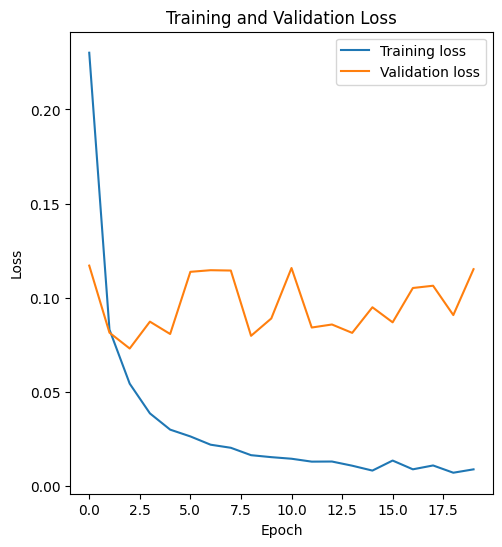

In [12]:
# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


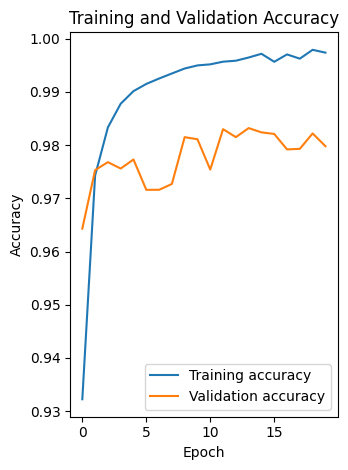

In [13]:
# Plot training & validation accuracy values


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

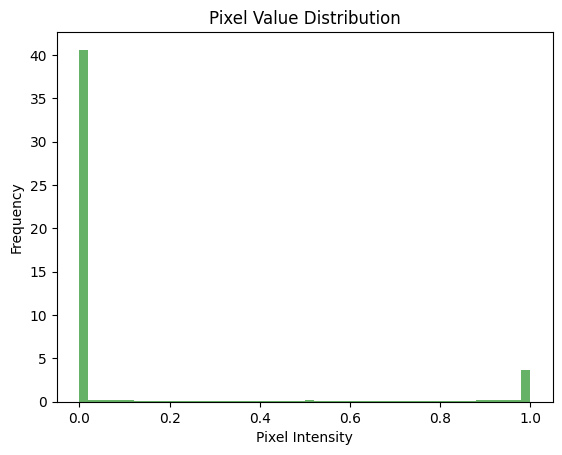

Mean: 0.13066044449806213, Standard Deviation: 0.3081078827381134


(0.13066044, 0.30810788)

In [14]:
def compute_statistics(dataset):
    pixel_values = np.concatenate([image.numpy().flatten() for image, label in dataset])
    
    mean = np.mean(pixel_values)
    std_dev = np.std(pixel_values)
    
    plt.hist(pixel_values, bins=50, density=True, alpha=0.6, color='g')
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()
    
    print(f"Mean: {mean}, Standard Deviation: {std_dev}")
    return mean, std_dev 


compute_statistics(ds_train)


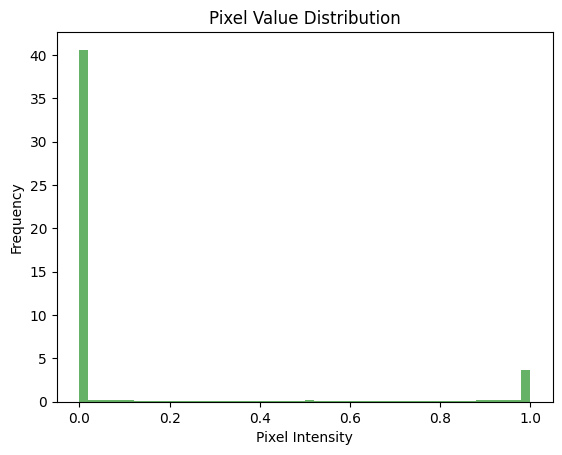

Mean: 0.13066044449806213, Standard Deviation: 0.3081078827381134


In [15]:
mean_value, std_dev_value = compute_statistics(ds_train)

In [16]:
# Function to filter out noisy images based on mean and standard deviation
def filter_noisy_images(dataset, mean, std_dev, threshold=2.0):
    filtered_dataset = []
    for image, label in dataset:
        pixel_values = image.numpy().flatten()
        image_mean = np.mean(pixel_values)
        image_std_dev = np.std(pixel_values)
        if np.abs(image_mean - mean) < threshold * std_dev:
            filtered_dataset.append((image, label))
    return filtered_dataset


In [17]:
# Calculate mean and std_dev for the entire training set
mean_value = np.mean([np.mean(image.numpy().flatten()) for image, label in ds_train])
std_dev_value = np.std([np.std(image.numpy().flatten()) for image, label in ds_train])


In [18]:
def compute_loss_in_batches(model, dataset):
    total_loss = 0.0
    num_batches = 0
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    for batch in dataset:
        images, labels = batch
        logits = model(images, training=False)
        loss = loss_fn(labels, logits)
        total_loss += loss.numpy()
        num_batches += 1
    
    return total_loss / num_batches

In [29]:
# # Compute and print the cross-entropy loss for the training and test datasets
# train_loss = compute_loss_in_batches(model, ds_train)
# test_loss = compute_loss_in_batches(model, ds_test)

# print(f"Train Loss: {train_loss}")
# print(f"Test Loss: {test_loss}")
train_loss = history.history['loss']
test_loss = history.history['val_loss']


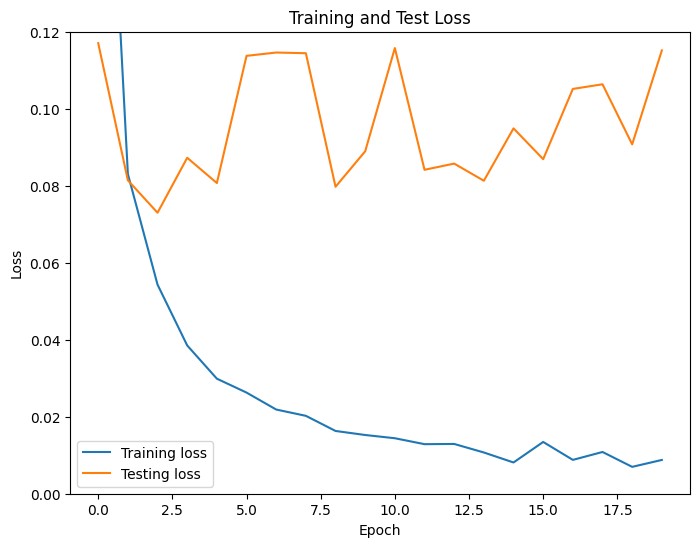

In [30]:
# Plot training and validation loss values
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.12)  # Remember to set the y-axis limits to focus on small loss values
plt.legend()
plt.show()


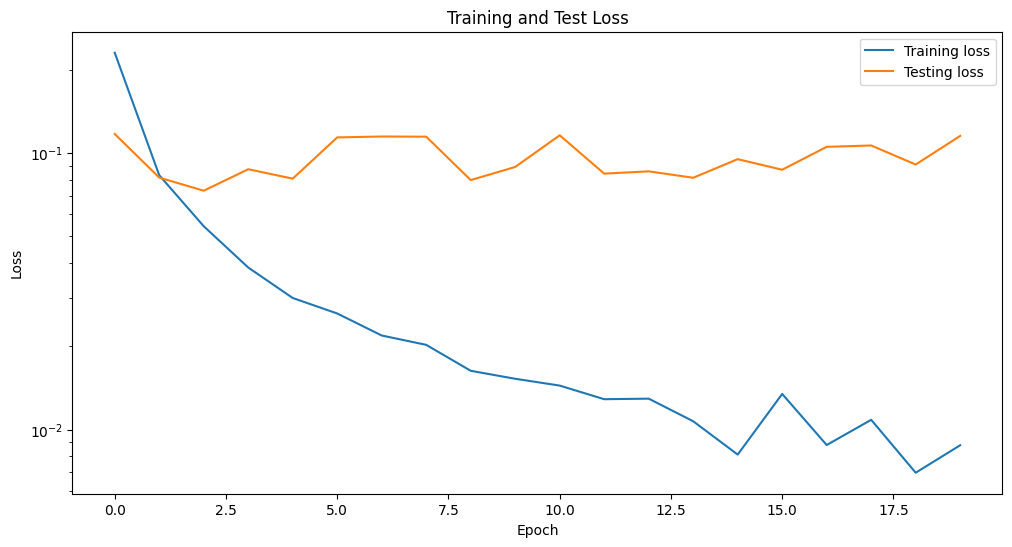

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.show()

Testing the Data

In [21]:
model.evaluate(ds_test)

79/79 [==============================] - 2s 30ms/step - loss: 0.1151 - accuracy: 0.9798


[0.11514551937580109, 0.9797999858856201]